# Recommendation System
**Data from Netflix**

*   combine_data_*.txt - This text file contains movie_id, customer_id, rating, date
*   movie_titles.csv - This CSV file contains movie_id and movie_title

**Import Packages**

In [115]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

import pickle
import math
import re
import time
import gc

# Load Data

*   combine_data_*.txt :- Read from this file. This is a comma separated file. It includes movie_id, customer_id, rating and date
*   netflix_rating.csv :- This is a csv file generated by reading from the combine_data_*.txt file

In [117]:
df1 = pd.read_csv('../NetflixPrizeData/combined_data_1_v2.csv', header = None, names = ['CustomerID', 'Rating','Date','MovieID'], usecols = [0,1,2,3])
df2 = pd.read_csv('../NetflixPrizeData/combined_data_2_v2.csv', header = None, names = ['CustomerID', 'Rating','Date','MovieID'], usecols = [0,1,2,3])
df3 = pd.read_csv('../NetflixPrizeData/combined_data_3_v2.csv', header = None, names = ['CustomerID', 'Rating','Date','MovieID'], usecols = [0,1,2,3])
df4 = pd.read_csv('../NetflixPrizeData/combined_data_4_v2.csv', header = None, names = ['CustomerID', 'Rating','Date','MovieID'], usecols = [0,1,2,3])

df1['Rating'] = df1['Rating'].astype(float)
df2['Rating'] = df2['Rating'].astype(float)
df3['Rating'] = df3['Rating'].astype(float)
df4['Rating'] = df4['Rating'].astype(float)

df = df1.append(df2)
df = df.append(df3)
df = df.append(df4)

df.index = np.arange(0,len(df))
print('Full dataset shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Full dataset shape: (100480507, 4)
-Dataset examples-
           CustomerID  Rating        Date  MovieID
0             1488844     3.0  2005-09-06        1
5000000        501954     2.0  2004-08-26      996
10000000       404654     5.0  2005-08-29     1962
15000000       886608     2.0  2005-09-19     2876
20000000      1193835     2.0  2003-08-13     3825
25000000      1899206     3.0  2004-10-15     4661
30000000       154804     4.0  2005-01-27     5496
35000000      2078749     5.0  2003-01-04     6274
40000000       450763     5.0  2005-07-19     7057
45000000       102092     3.0  2003-08-26     7991
50000000       220298     5.0  2005-07-18     9023
55000000       550530     5.0  2005-07-08    10042
60000000       222570     3.0  2005-08-09    11038
65000000      1273080     5.0  2004-12-31    11875
70000000      2026970     5.0  2005-08-26    12676
75000000       506044     4.0  2004-09-28    13582
80000000       353605     2.0  2005-07-10    14453
85000000       664606     3.

**Check for the duplicate records**

In [113]:
df.duplicated(['MovieID','CustomerID','Rating','Date']).sum()

0

# Analysis of Data

Count of Ratings - 1, 2, 3, 4, 5

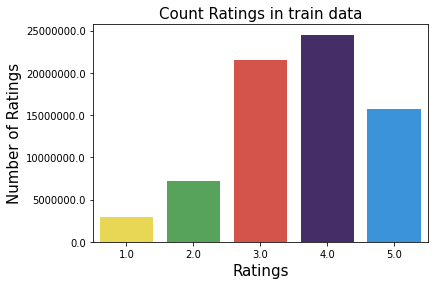

In [116]:
plt.figure(figsize = (6, 4))
ax = sns.countplot(x="Rating", data=df, palette=['#ffeb3b',"#4caf50","#eb4034",'#432371','#2196f3'])
ax.set_yticklabels([num for num in ax.get_yticks()])
plt.tick_params(labelsize = 10)
plt.title("Count Ratings in train data", fontsize = 15)
plt.xlabel("Ratings", fontsize = 15)
plt.ylabel("Number of Ratings", fontsize = 15)
plt.show()

# Data Slicing

**One of the major challenges is to get all the data loaded into the Kernel for analysis.**

**Remove ratings from users and for movies with number of reviews less than the minimum threshold**


The data set now is super huge. I have tried many different ways but can't get the Kernel running as intended without memory error. Therefore I tried to reduce the data volumn by improving the data quality below:

Remove movie with too less reviews (they are relatively not popular)
Remove customer who give too less reviews (they are relatively less active)
Having above benchmark will have significant improvement on efficiency, since those unpopular movies and non-active customers still occupy same volumn as those popular movies and active customers in the view of matrix (NaN still occupy space). This should help improve the statistical signifiance too.

In [118]:
#Min ratings for movies and users
f = ['count','mean']

df_movie_summary = df.groupby('MovieID')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.7),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('CustomerID')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.7),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 1948.0
Customer minimum times of review: 211.0


In [119]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['MovieID'].isin(drop_movie_list)]
df = df[~df['CustomerID'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))

Original Shape: (100480507, 4)
After Trim Shape: (71833509, 4)


# Create Sample Dataframe

This method will be used to generate Sample Dataframe containing 100000 (1 million) rows.

In [120]:
sample_df = df.sample(n = 1000000) 
sample_df.sort_values(by=['CustomerID','MovieID'], inplace=True)
sample_df

,CustomerID,Rating,Date,MovieID
6067114,6,3.0,2004-12-13,1180
34903215,6,3.0,2005-11-24,6255
43176003,6,3.0,2004-11-17,7624
58694295,6,4.0,2004-03-09,10774
80842253,6,4.0,2005-01-12,14545
...,...,...,...,...
85484603,2649426,4.0,2002-09-27,15158
16891261,2649429,5.0,2003-11-18,3275
29115853,2649429,4.0,2005-12-23,5327
32504256,2649429,3.0,2003-10-14,5924


In [121]:
print(df['CustomerID'].nunique())
print(sample_df['CustomerID'].nunique())

144380
142440


In [122]:
print(len(df['MovieID'].unique()))
print(len(sample_df['MovieID'].unique()))

5332
5332


In [123]:
#Pivot table with MovieID as index
features_matrix = pd.pivot_table(sample_df,values='Rating',index='CustomerID',columns='MovieID',fill_value=0.0)

features_matrix

MovieID,3,8,16,17,18,26,28,30,33,44,...,17741,17743,17751,17756,17758,17761,17762,17763,17764,17769
CustomerID,,,,,,,,,,,,,,,,,,,,,
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
79,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2649370,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2649378,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2649388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [124]:
features_matrix_sample = features_matrix.sample(n=100).sample(n=100, axis=1)

features_matrix_sample

MovieID,17314,7354,8818,13996,6529,3095,15329,11266,15545,11518,...,7117,10217,14056,1521,1760,10704,12263,9274,10712,9364
CustomerID,,,,,,,,,,,,,,,,,,,,,
816128,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1390290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
328509,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1462175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1101454,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1810743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1404669,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Matrix factorization

    '''
    R: rating matrix
    P: |U| * K (User features matrix)
    Q: |D| * K (Item features matrix)
    K: latent features
    steps: iterations
    gamma: learning rate
    lambdaP: regularization parameter'''

In [125]:
def matrix_factorization(R, P, Q, K, steps=5000, gamma=0.0002, lambdaP=0.02):
    Q = Q.T

    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    # calculate error
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])

                    for k in range(K):
                        # calculate gradient with a and lambdaP parameter
                        P[i][k] = P[i][k] + gamma * (2 * eij * Q[k][j] - lambdaP * P[i][k])
                        Q[k][j] = Q[k][j] + gamma * (2 * eij * P[i][k] - lambdaP * Q[k][j])

        eR = np.dot(P,Q)

        e = 0

        for i in range(len(R)):

            for j in range(len(R[i])):

                if R[i][j] > 0:

                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)

                    for k in range(K):

                        e = e + (lambdaP/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        # 0.001: local minimum
        if e < 0.001:

            break

    return P, Q.T

In [135]:
features_matrix_array = features_matrix.to_numpy()

# N: num of User
N = len(features_matrix_array)
# M: num of Movie
M = len(features_matrix_array[0])
# Num of Features
K = 5
 
P = np.random.rand(N,K)
Q = np.random.rand(M,K)

nP, nQ = matrix_factorization(features_matrix_array, P, Q, K)

nR = np.dot(nP, nQ.T)
nR


KeyboardInterrupt



In [133]:
keys = features_matrix_sample.index
movies = list(features_matrix_sample.columns) 
user_dict = {}
for i in range(len(nR)):
    user_dict[keys[i]] = nR[i]
user_dict[1462175]

array([1.43352798, 2.40827888, 1.60342969, 2.29254503, 1.34026016,
       2.38629826, 0.83896098, 1.17220046, 2.31186435, 2.59942121,
       0.88038649, 2.08632954, 2.49746211, 1.89578519, 1.48123685,
       2.54000615, 2.14956418, 2.85369471, 2.58388334, 3.0977654 ,
       2.52298125, 3.25768988, 2.10928133, 2.32317065, 1.8834545 ,
       2.45767658, 1.45136283, 2.74390961, 2.06975686, 2.09546117,
       0.86835538, 1.98440168, 1.63999073, 2.03926707, 3.08844671,
       2.00458997, 1.65291788, 1.285199  , 3.33355161, 3.1876437 ,
       1.84734242, 1.21708186, 1.90992952, 1.25910223, 1.6588806 ,
       2.46751502, 1.73721507, 1.73886471, 1.06565637, 1.20205221,
       1.38707362, 1.58168818, 2.39514992, 1.81599987, 1.75146866,
       1.97127498, 2.62656893, 1.42319802, 1.91708194, 1.64529609,
       2.47190517, 1.42867753, 1.33851145, 1.74604543, 2.58234672,
       2.35589689, 1.53307313, 2.7720881 , 2.63031776, 2.15434639,
       1.7135023 , 1.25605223, 2.35620451, 1.50833686, 1.39787

# Load Movie Titles

In [78]:
movie_titles_df = pd.read_csv('../NetflixPrizeData/movie_titles2.csv', encoding = "ISO-8859-1", sep = ",", header = None, names = ['Movie_Id', 'Year', 'Name'],usecols = [0,1,2])
movie_titles_df.set_index('Movie_Id', inplace = True)
movie_titles_df.head()

,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


# Make Recommendations

In [129]:
def get_top_n_movie_recommendations(user_id,n):
    arr = user_dict[user_id]
    # sort an array in ascending order np.argsort() return array of indices for sorted array 
    sorted_index_array = np.argsort(arr) 
    sorted_array = arr[sorted_index_array] 
    # we are using negative indexing concept to find n largest values
    rslt = sorted_array[-n : ] 
    f = np.array(sorted_index_array[-n : ])
    print("{} largest value:".format(n), rslt) 
    print("{} largest indexes:".format(n), f) 
    
    movie_ids_list = np.array(movies)[f.astype(int)]
    print(movie_ids_list)

    reco_df = movie_titles_df.loc[movie_ids_list,:]
    reco_df['Score'] = rslt
    reco_df.sort_values(by=['Score'],ascending=False, inplace=True)
    print('Top {} movie recommendations for User {}:'.format(n,user_id))
    print(reco_df)


In [134]:
get_top_n_movie_recommendations(1462175,10)

10 largest value: [2.74390961 2.7720881  2.85369471 2.92673101 3.07401103 3.08844671
 3.0977654  3.1876437  3.25768988 3.33355161]
10 largest indexes: [27 67 17 79 86 34 19 39 21 38]
[15084  2521  2072  4612 17563  3216  6528 10275 11186  3168]
Top 10 movie recommendations for User 1462175:
            Year                       Name     Score
Movie_Id                                             
3168      1987.0  Evil Dead 2: Dead by Dawn  3.333552
11186     1992.0               Far and Away  3.257690
10275     2004.0         The Girl Next Door  3.187644
6528      1998.0               Oz: Season 2  3.097765
3216      1986.0   Children of a Lesser God  3.088447
17563     1962.0                     Lolita  3.074011
4612      1994.0                    Timecop  2.926731
2072      1989.0                        K-9  2.853695
2521      1988.0                  Punchline  2.772088
15084     1995.0          Leaving Las Vegas  2.743910
